In [1]:
#

In [2]:
# --- Cell 2: Symmetric Cipher Benchmark (AES vs. ChaCha20) ---

import os
import time
import pandas as pd
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.ciphers.aead import AESGCM, ChaCha20Poly1305
from cryptography.hazmat.primitives import hashes, hmac
from cryptography.hazmat.backends import default_backend

# --- Configuration ---
# Test various data sizes to see how overhead affects performance
DATA_SIZES_TO_TEST = {
    "1KB": 1024,
    "1MB": 1024 * 1024,
    "100MB": 100 * 1024 * 1024
}
NUM_ITERATIONS_LARGE = 5
NUM_ITERATIONS_SMALL = 100 # Use more iterations for small data

print(f"Starting symmetric benchmark (V2)...")

# --- Setup Paths ---
# Use os.getcwd() for interactive environments like Colab/Jupyter
SCRIPT_DIRECTORY = os.getcwd()
RESULTS_FOLDER = os.path.join(SCRIPT_DIRECTORY, "results")
os.makedirs(RESULTS_FOLDER, exist_ok=True)
print(f"Saving results to: {RESULTS_FOLDER}")

# --- Generate Test Data ---
print("Generating test data...")
test_data = {}
for name, size in DATA_SIZES_TO_TEST.items():
    test_data[name] = os.urandom(size)
print("Test data generated.\n")

symmetric_results = []

def get_iterations(size_bytes):
    return NUM_ITERATIONS_SMALL if size_bytes < (1024 * 1024) else NUM_ITERATIONS_LARGE

def benchmark_aes_gcm(data, data_name, key_size_bits):
    """Benchmarks AES-GCM (Authenticated Encryption)."""
    size_bytes = len(data)
    num_iterations = get_iterations(size_bytes)
    print(f"Testing: AES-{key_size_bits} GCM ({data_name}, {num_iterations} iter)")

    key = AESGCM.generate_key(bit_length=key_size_bits)
    aes_gcm = AESGCM(key)
    nonce = os.urandom(12) 
    
    # --- Encrypt Test ---
    start_time = time.perf_counter()
    for _ in range(num_iterations):
        ciphertext = aes_gcm.encrypt(nonce, data, None)
    end_time = time.perf_counter()
    
    total_time = end_time - start_time
    total_data_mb = (size_bytes / (1024*1024)) * num_iterations
    encrypt_throughput = total_data_mb / total_time
    
    # --- Decrypt Test ---
    start_time = time.perf_counter()
    for _ in range(num_iterations):
        plaintext = aes_gcm.decrypt(nonce, ciphertext, None)
    end_time = time.perf_counter()
    
    total_time = end_time - start_time
    decrypt_throughput = total_data_mb / total_time
    
    symmetric_results.append({
        "Algorithm": "AES",
        "Key Size": key_size_bits,
        "Mode": "GCM (AEAD)",
        "Data Size": data_name,
        "Encrypt (MB/s)": encrypt_throughput,
        "Decrypt (MB/s)": decrypt_throughput
    })

def benchmark_chacha20_poly1305(data, data_name):
    """Benchmarks ChaCha20-Poly1305 (Authenticated Encryption)."""
    size_bytes = len(data)
    num_iterations = get_iterations(size_bytes)
    print(f"Testing: ChaCha20-Poly1305 ({data_name}, {num_iterations} iter)")
    
    key = ChaCha20Poly1305.generate_key() # 256-bit key
    chacha = ChaCha20Poly1305(key)
    nonce = os.urandom(12)
    
    # --- Encrypt Test ---
    start_time = time.perf_counter()
    for _ in range(num_iterations):
        ciphertext = chacha.encrypt(nonce, data, None)
    end_time = time.perf_counter()
    
    total_time = end_time - start_time
    total_data_mb = (size_bytes / (1024*1024)) * num_iterations
    encrypt_throughput = total_data_mb / total_time
    
    # --- Decrypt Test ---
    start_time = time.perf_counter()
    for _ in range(num_iterations):
        plaintext = chacha.decrypt(nonce, ciphertext, None)
    end_time = time.perf_counter()
    
    total_time = end_time - start_time
    decrypt_throughput = total_data_mb / total_time
    
    symmetric_results.append({
        "Algorithm": "ChaCha20",
        "Key Size": 256,
        "Mode": "Poly1305 (AEAD)",
        "Data Size": data_name,
        "Encrypt (MB/s)": encrypt_throughput,
        "Decrypt (MB/s)": decrypt_throughput
    })

# --- Run Benchmarks ---
print("Running symmetric benchmarks, this may take a moment...\n")

for name, data in test_data.items():
    benchmark_aes_gcm(data, name, 128)
    benchmark_aes_gcm(data, name, 256)
    benchmark_chacha20_poly1305(data, name)

print("\n--- Symmetric Benchmark Complete ---")

# --- Display Results in a Clean Table ---
df_symmetric = pd.DataFrame(symmetric_results)
df_symmetric = df_symmetric.round(4) # Round to 4 decimal places

# --- SAVE TO FILE (CSV) ---
output_filename_csv = "symmetric_benchmark_results.csv"
full_output_path = os.path.join(RESULTS_FOLDER, output_filename_csv)
df_symmetric.to_csv(full_output_path, index=False)
print(f"\n✅ Symmetric results successfully saved to: {full_output_path}")
# ---------------------------

print("\n--- Symmetric Benchmark Results ---")
try:
    print(df_symmetric.to_markdown(index=False))
except ImportError:
    print(df_symmetric)


Starting symmetric benchmark (V2)...
Saving results to: /Users/luismartinez/Documents/grad courses/csce703/CSCE-477-Team9/results
Generating test data...
Test data generated.

Running symmetric benchmarks, this may take a moment...

Testing: AES-128 GCM (1KB, 100 iter)
Testing: AES-256 GCM (1KB, 100 iter)
Testing: ChaCha20-Poly1305 (1KB, 100 iter)
Testing: AES-128 GCM (1MB, 5 iter)
Testing: AES-256 GCM (1MB, 5 iter)
Testing: ChaCha20-Poly1305 (1MB, 5 iter)
Testing: AES-128 GCM (100MB, 5 iter)
Testing: AES-256 GCM (100MB, 5 iter)
Testing: ChaCha20-Poly1305 (100MB, 5 iter)

--- Symmetric Benchmark Complete ---

✅ Symmetric results successfully saved to: /Users/luismartinez/Documents/grad courses/csce703/CSCE-477-Team9/results/symmetric_benchmark_results.csv

--- Symmetric Benchmark Results ---
| Algorithm   |   Key Size | Mode            | Data Size   |   Encrypt (MB/s) |   Decrypt (MB/s) |
|:------------|-----------:|:----------------|:------------|-----------------:|-----------------:|

In [3]:
# --- Cell 3: Asymmetric Cipher Benchmark (RSA vs. ECC) ---

import time
import tracemalloc # Import for memory tracking
# pandas, os, and other libraries were imported in the cell above

from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import rsa, ec, padding
from cryptography.hazmat.backends import default_backend

# --- Configuration ---
NUM_ITERATIONS_ASYMMETRIC = 100 
print(f"Starting asymmetric benchmark (V3)...")
print(f"Iterations per test: {NUM_ITERATIONS_ASYMMETRIC}\n")

# --- Setup Paths (already done, but good to have for this cell) ---
SCRIPT_DIRECTORY = os.getcwd()
RESULTS_FOLDER = os.path.join(SCRIPT_DIRECTORY, "results")
os.makedirs(RESULTS_FOLDER, exist_ok=True)
print(f"Saving results to: {RESULTS_FOLDER}")

# --- Generate Test Data ---
data_hash = os.urandom(32) # 32-byte hash (simulates SHA-256)
print("Test data (32-byte hash) generated.\n")

# This list will store our results
asymmetric_results = []

def benchmark_rsa(key_size_bits):
    """
    Benchmarks RSA for key generation, signing, and verification.
    Also measures peak memory usage for each.
    
    Returns a dictionary of results.
    """
    print(f"Testing: RSA {key_size_bits}-bit")
    
    # --- 1. Key Generation ---
    tracemalloc.start()
    start_time = time.perf_counter()
    
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=key_size_bits,
        backend=default_backend()
    )
    
    key_gen_time = time.perf_counter() - start_time
    _, key_gen_peak_mem = tracemalloc.get_traced_memory() # current, peak
    tracemalloc.stop()
    
    public_key = private_key.public_key()
    
    # --- 2. Sign Test ---
    tracemalloc.start()
    start_time = time.perf_counter()
    
    for _ in range(NUM_ITERATIONS_ASYMMETRIC):
        signature = private_key.sign(
            data_hash,
            padding.PSS( 
                mgf=padding.MGF1(hashes.SHA256()),
                salt_length=padding.PSS.MAX_LENGTH
            ),
            hashes.SHA256()
        )
        
    avg_sign_time = (time.perf_counter() - start_time) / NUM_ITERATIONS_ASYMMETRIC
    _, sign_peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    # --- 3. Verify Test ---
    tracemalloc.start()
    start_time = time.perf_counter()
    
    for _ in range(NUM_ITERATIONS_ASYMMETRIC):
        public_key.verify(
            signature,
            data_hash,
            padding.PSS(
                mgf=padding.MGF1(hashes.SHA256()),
                salt_length=padding.PSS.MAX_LENGTH
            ),
            hashes.SHA256()
        )
        
    avg_verify_time = (time.perf_counter() - start_time) / NUM_ITERATIONS_ASYMMETRIC
    _, verify_peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    # --- 4. Return results as a dictionary ---
    return {
        "Algorithm": "RSA",
        "Key": f"{key_size_bits}-bit",
        "Security (approx)": f"~{112 if key_size_bits == 2048 else 128}-bit",
        "Key Gen (s)": key_gen_time,
        "Sign (s)": avg_sign_time,
        "Verify (s)": avg_verify_time,
        "Key Gen Peak (KiB)": key_gen_peak_mem / 1024,
        "Sign Peak (KiB)": sign_peak_mem / 1024,
        "Verify Peak (KiB)": verify_peak_mem / 1024
    }

def benchmark_ecc(curve, curve_name, security_equiv):
    """
    Benchmarks ECC for key generation, signing, and verification.
    Also measures peak memory usage for each.
    
    Returns a dictionary of results.
    """
    print(f"Testing: ECC {curve_name}")
    
    # --- 1. Key Generation ---
    tracemalloc.start()
    start_time = time.perf_counter()
    
    private_key = ec.generate_private_key(
        curve, backend=default_backend()
    )
    
    key_gen_time = time.perf_counter() - start_time
    _, key_gen_peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    public_key = private_key.public_key()
    
    # --- 2. Sign Test ---
    tracemalloc.start()
    start_time = time.perf_counter()
    
    for _ in range(NUM_ITERATIONS_ASYMMETRIC):
        signature = private_key.sign(
            data_hash,
            ec.ECDSA(hashes.SHA256())
        )
        
    avg_sign_time = (time.perf_counter() - start_time) / NUM_ITERATIONS_ASYMMETRIC
    _, sign_peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    # --- 3. Verify Test ---
    tracemalloc.start()
    start_time = time.perf_counter()
    
    for _ in range(NUM_ITERATIONS_ASYMMETRIC):
        public_key.verify(
            signature,
            data_hash,
            ec.ECDSA(hashes.SHA256())
        )
        
    avg_verify_time = (time.perf_counter() - start_time) / NUM_ITERATIONS_ASYMMETRIC
    _, verify_peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # --- 4. Return results as a dictionary ---
    return {
        "Algorithm": "ECC",
        "Key": curve_name,
        "Security (approx)": f"~{security_equiv}-bit",
        "Key Gen (s)": key_gen_time,
        "Sign (s)": avg_sign_time,
        "Verify (s)": avg_verify_time,
        "Key Gen Peak (KiB)": key_gen_peak_mem / 1024,
        "Sign Peak (KiB)": sign_peak_mem / 1024,
        "Verify Peak (KiB)": verify_peak_mem / 1024
    }

# --- Run Benchmarks ---
print("Running asymmetric benchmarks, this may take a moment...\n")

# --- RSA Tests ---
asymmetric_results.append(benchmark_rsa(2048))
asymmetric_results.append(benchmark_rsa(3072))

# --- ECC Tests ---
asymmetric_results.append(benchmark_ecc(ec.SECP256R1(), "P-256 (secp256r1)", 128))
asymmetric_results.append(benchmark_ecc(ec.SECP384R1(), "P-384 (secp384r1)", 192))

print("\n--- Asymmetric Benchmark Complete ---")

# --- Display Results in a Clean Table ---
df_asymmetric = pd.DataFrame(asymmetric_results)
df_asymmetric = df_asymmetric.round(6) 

# --- SAVE TO FILE (CSV) ---
output_filename_csv = "asymmetric_benchmark_results.csv"
full_output_path = os.path.join(RESULTS_FOLDER, output_filename_csv)
df_asymmetric.to_csv(full_output_path, index=False)
print(f"\n✅ Asymmetric results successfully saved to: {full_output_path}")
# ---------------------------

print("\n--- Asymmetric Benchmark Results (V3) ---")
try:
    print(df_asymmetric.to_markdown(index=False))
except ImportError:
    print(df_asymmetric)

Starting asymmetric benchmark (V3)...
Iterations per test: 100

Saving results to: /Users/luismartinez/Documents/grad courses/csce703/CSCE-477-Team9/results
Test data (32-byte hash) generated.

Running asymmetric benchmarks, this may take a moment...

Testing: RSA 2048-bit
Testing: RSA 3072-bit
Testing: ECC P-256 (secp256r1)
Testing: ECC P-384 (secp384r1)

--- Asymmetric Benchmark Complete ---

✅ Asymmetric results successfully saved to: /Users/luismartinez/Documents/grad courses/csce703/CSCE-477-Team9/results/asymmetric_benchmark_results.csv

--- Asymmetric Benchmark Results (V3) ---
| Algorithm   | Key               | Security (approx)   |   Key Gen (s) |   Sign (s) |   Verify (s) |   Key Gen Peak (KiB) |   Sign Peak (KiB) |   Verify Peak (KiB) |
|:------------|:------------------|:--------------------|--------------:|-----------:|-------------:|---------------------:|------------------:|--------------------:|
| RSA         | 2048-bit          | ~112-bit            |      0.074117 | 

Starting visualization script...
Plotting symmetric results from /Users/luismartinez/Documents/grad courses/csce703/CSCE-477-Team9/results/symmetric_benchmark_results.csv...
  -> Saved chart to: /Users/luismartinez/Documents/grad courses/csce703/CSCE-477-Team9/results/symmetric_encrypt_throughput.png


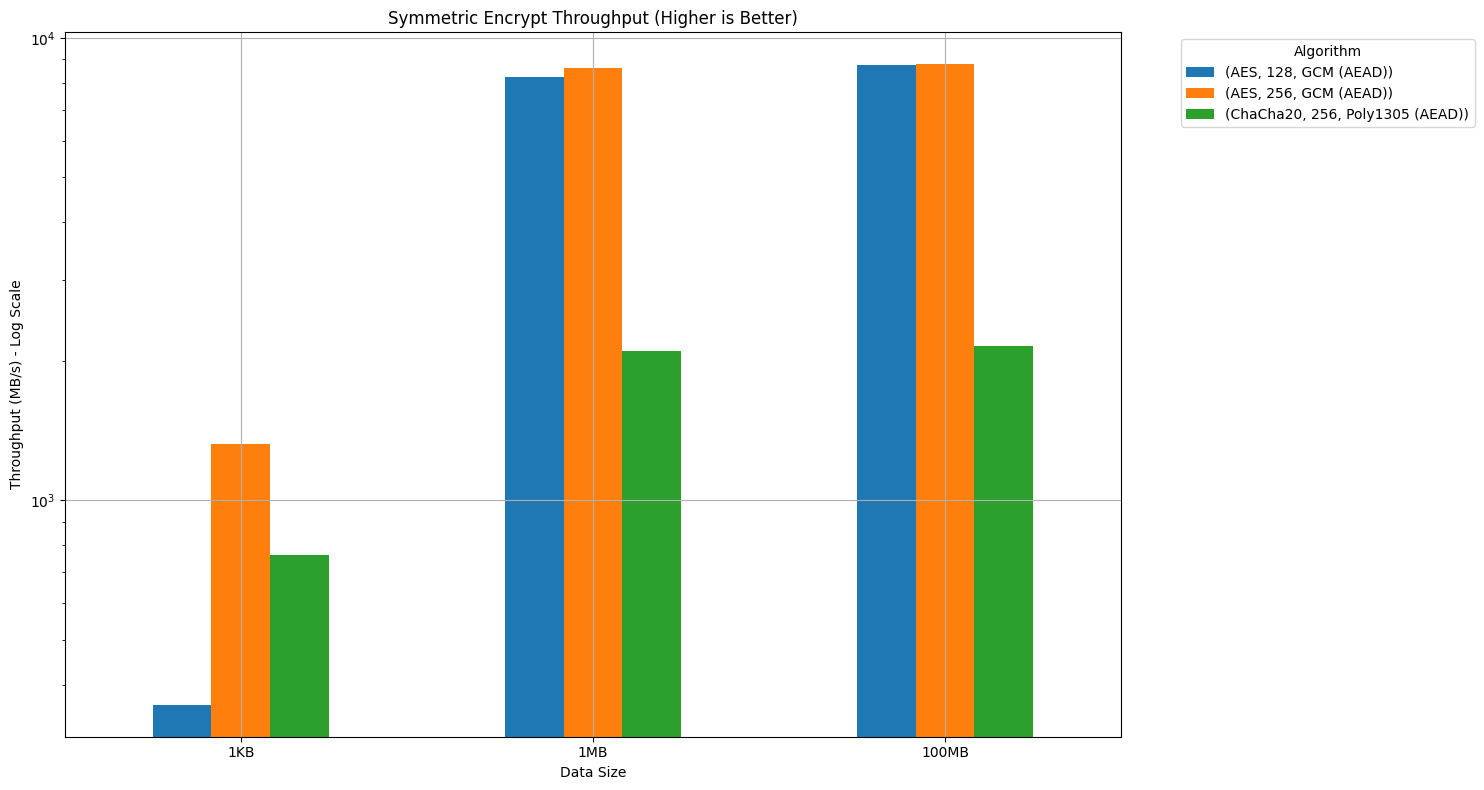

Plotting asymmetric results from /Users/luismartinez/Documents/grad courses/csce703/CSCE-477-Team9/results/asymmetric_benchmark_results.csv...
  -> Saved chart to: /Users/luismartinez/Documents/grad courses/csce703/CSCE-477-Team9/results/asymmetric_key_gen_time.png


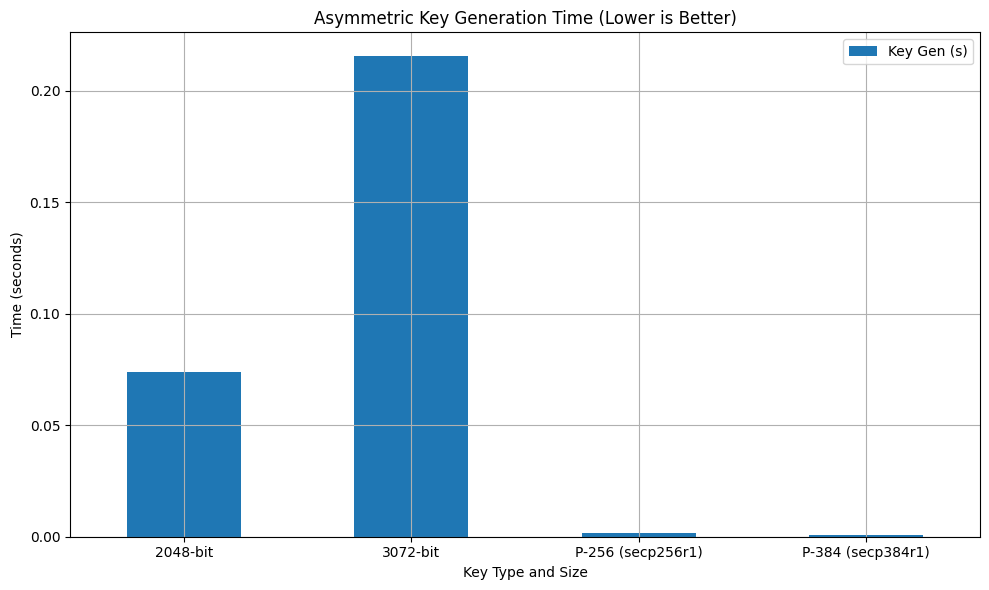

  -> Saved chart to: /Users/luismartinez/Documents/grad courses/csce703/CSCE-477-Team9/results/asymmetric_sign_verify_time.png


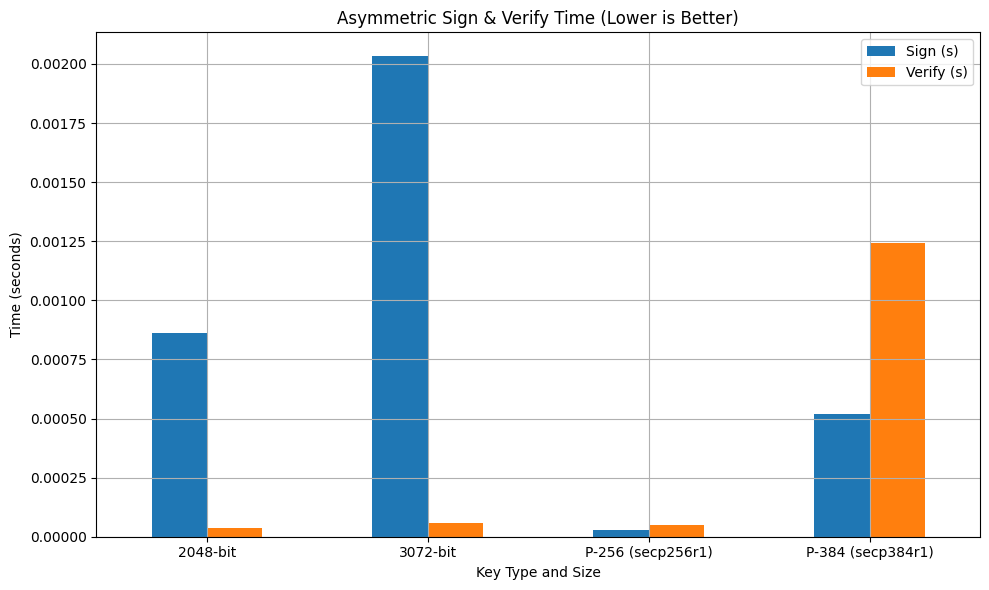

  -> Saved chart to: /Users/luismartinez/Documents/grad courses/csce703/CSCE-477-Team9/results/asymmetric_key_gen_memory.png


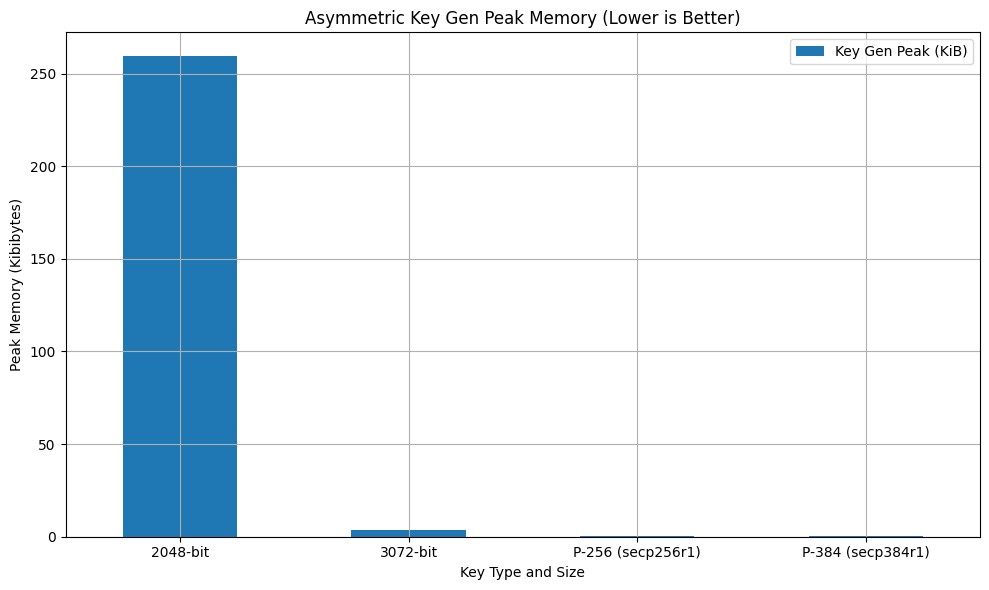


Visualization complete. Check the 'results' folder for your .png charts.


In [4]:
# --- Cell 4: Visualize Results ---

import matplotlib.pyplot as plt
import sys
# pandas and os were imported in the cells above

# --- Setup Paths ---
SCRIPT_DIRECTORY = os.getcwd()
RESULTS_FOLDER = os.path.join(SCRIPT_DIRECTORY, "results")
SYMMETRIC_CSV = os.path.join(RESULTS_FOLDER, "symmetric_benchmark_results.csv")
ASYMMETRIC_CSV = os.path.join(RESULTS_FOLDER, "asymmetric_benchmark_results.csv")

print("Starting visualization script...")
if not os.path.exists(RESULTS_FOLDER):
    print(f"Error: 'results' folder not found at {RESULTS_FOLDER}", file=sys.stderr)
    # sys.exit(1) # We use 'return' or 'pass' in a notebook
else:
    def plot_symmetric_results(filepath):
        """Plots the symmetric benchmark results."""
        print(f"Plotting symmetric results from {filepath}...")
        try:
            df = pd.read_csv(filepath)
        except FileNotFoundError:
            print(f"Error: Could not find {filepath}. Run Cell 2 first.", file=sys.stderr)
            return

        # We need to pivot the data to make it easy to plot
        # Let's fix the pivot to handle the columns we have
        df_pivot = df.pivot_table(index='Data Size', 
                                  columns=['Algorithm', 'Key Size', 'Mode'], 
                                  values='Encrypt (MB/s)')
        
        # Re-order for a logical chart
        try:
            df_pivot = df_pivot.reindex(['1KB', '1MB', '100MB'])
        except KeyError:
            print("Warning: Not all data sizes (1KB, 1MB, 100MB) were found. Plotting as-is.")

        # --- Plot 1: Encrypt Throughput ---
        ax = df_pivot.plot(kind='bar',
                             title='Symmetric Encrypt Throughput (Higher is Better)',
                             figsize=(15, 8),
                             rot=0,
                             grid=True)
        ax.set_ylabel('Throughput (MB/s) - Log Scale')
        ax.set_xlabel('Data Size')
        ax.set_yscale('log') # Use log scale, 1KB and 100MB results are vastly different
        ax.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        save_path = os.path.join(RESULTS_FOLDER, 'symmetric_encrypt_throughput.png')
        plt.savefig(save_path)
        print(f"  -> Saved chart to: {save_path}")
        plt.show() # Display the plot inline
        plt.close()

    def plot_asymmetric_results(filepath):
        """Plots the asymmetric benchmark results."""
        print(f"Plotting asymmetric results from {filepath}...")
        try:
            df = pd.read_csv(filepath)
        except FileNotFoundError:
            print(f"Error: Could not find {filepath}. Run Cell 3 first.", file=sys.stderr)
            return

        # --- Plot 1: Key Generation Time ---
        ax = df.plot(kind='bar', x='Key', y='Key Gen (s)',
                       title='Asymmetric Key Generation Time (Lower is Better)',
                       figsize=(10, 6),
                       rot=0,
                       grid=True)
        ax.set_ylabel('Time (seconds)')
        ax.set_xlabel('Key Type and Size')
        plt.tight_layout()
        
        save_path = os.path.join(RESULTS_FOLDER, 'asymmetric_key_gen_time.png')
        plt.savefig(save_path)
        print(f"  -> Saved chart to: {save_path}")
        plt.show() # Display the plot inline
        plt.close()

        # --- Plot 2: Sign & Verify Time ---
        df.plot(kind='bar', x='Key', y=['Sign (s)', 'Verify (s)'],
                title='Asymmetric Sign & Verify Time (Lower is Better)',
                figsize=(10, 6),
                rot=0,
                grid=True)
        plt.ylabel('Time (seconds)')
        plt.xlabel('Key Type and Size')
        plt.tight_layout()
        
        save_path = os.path.join(RESULTS_FOLDER, 'asymmetric_sign_verify_time.png')
        plt.savefig(save_path)
        print(f"  -> Saved chart to: {save_path}")
        plt.show() # Display the plot inline
        plt.close()
        
        # --- Plot 3: Key Generation Memory ---
        ax = df.plot(kind='bar', x='Key', y='Key Gen Peak (KiB)',
                       title='Asymmetric Key Gen Peak Memory (Lower is Better)',
                       figsize=(10, 6),
                       rot=0,
                       grid=True)
        ax.set_ylabel('Peak Memory (Kibibytes)')
        ax.set_xlabel('Key Type and Size')
        plt.tight_layout()
        
        save_path = os.path.join(RESULTS_FOLDER, 'asymmetric_key_gen_memory.png')
        plt.savefig(save_path)
        print(f"  -> Saved chart to: {save_path}")
        plt.show() # Display the plot inline
        plt.close()


    # --- Run Plots ---
    if os.path.exists(SYMMETRIC_CSV):
        plot_symmetric_results(SYMMETRIC_CSV)
    else:
        print(f"Skipping symmetric plots, file not found: {SYMMETRIC_CSV}")

    if os.path.exists(ASYMMETRIC_CSV):
        plot_asymmetric_results(ASYMMETRIC_CSV)
    else:
        print(f"Skipping asymmetric plots, file not found: {ASYMMETRIC_CSV}")

    print("\nVisualization complete. Check the 'results' folder for your .png charts.")